# Nvidia (NVDA) Stock Prediction using LSTM

Long short-term memory networks (LSTMs) are essentially a specialized type of a recurrent neural network (RNN) used to learn sequential data and time series. LSTMs are more powerful in many tasks compared to vanilla RNNs as the usage of long-term memory cell states mitigate the risk of the vanishing and/or exploding gradient problem commonly encountered with vanilla RNNs.

In this notebook, an LSTM will be used to predict future Nvidia stocks. In fact, stock prediction is one of the most common examples where LSTMs are used in.

Note that, obviously, the actual stock market is naturally unpredictable and such models are not expected to work well due to the complexity of market dynamics, which involve not only historical prices but also macroeconomic factors, geopolitical events, and market sentiment. Nevertheless, LSTMs can provide useful insights and identify patterns in historical data, making them valuable tools for research and analysis in time-series forecasting.

## 0. Imports & Hyperparameters

In [1]:
# Necessary imports
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

# Hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 50
RNN_LAYERS = 2
HIDDEN_SIZE = 64
TRAIN_TEST_SPLIT = 0.90
LOOK_BACK = 7
BATCH_SIZE = 64
PLOT_STEPS = 1
PRINT_STEPS = 5

# Check PyTorch version
torch.__version__

'2.5.1+cpu'

## 1. Data Processing

In [2]:
df = pd.read_csv('data/NVDA.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6111,2024-04-18,849.700012,861.900024,824.020020,846.710022,846.710022,44726000
6112,2024-04-19,831.500000,843.239990,756.059998,762.000000,762.000000,87190500
6113,2024-04-22,781.039978,800.729980,764.000000,795.179993,795.179993,59634100
6114,2024-04-23,807.690002,827.690002,802.640015,824.229980,824.229980,43855900
6115,2024-04-24,839.500000,840.820007,791.830017,796.770020,796.770020,50961600


In [5]:
dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in list(df['Date'])]
prices = [float(p) for p in list(df['Close'])]

len(dates), len(prices)

(6116, 6116)

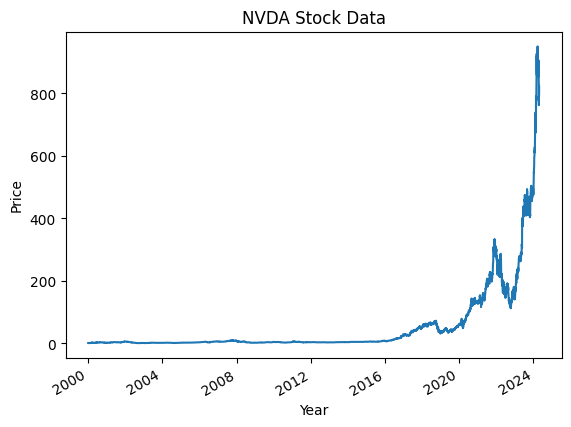

In [6]:
plt.title("NVDA Stock Data")
plt.xlabel("Year")
plt.ylabel("Price")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.plot(dates, prices);

In [7]:
def prepare_lookback_df(df):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, LOOK_BACK + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

shifted_df = prepare_lookback_df(df[['Date', 'Close']])
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-01-12,0.842448,0.864583,0.901042,0.872396,0.858073,0.917969,0.949219,0.975260
2000-01-13,0.877604,0.842448,0.864583,0.901042,0.872396,0.858073,0.917969,0.949219
2000-01-14,0.915365,0.877604,0.842448,0.864583,0.901042,0.872396,0.858073,0.917969
2000-01-18,0.954427,0.915365,0.877604,0.842448,0.864583,0.901042,0.872396,0.858073
2000-01-19,0.945313,0.954427,0.915365,0.877604,0.842448,0.864583,0.901042,0.872396
...,...,...,...,...,...,...,...,...
2024-04-18,846.710022,840.349976,874.150024,860.010010,881.859985,906.159973,870.390015,853.539978
2024-04-19,762.000000,846.710022,840.349976,874.150024,860.010010,881.859985,906.159973,870.390015
2024-04-22,795.179993,762.000000,846.710022,840.349976,874.150024,860.010010,881.859985,906.159973


In [8]:
shifted_np = shifted_df.to_numpy()
shifted_np.shape

(6109, 8)

In [9]:
scaler = MinMaxScaler((-1, 1))
shifted_np = scaler.fit_transform(shifted_np)

shifted_np

array([[-0.99951911, -0.99947248, -0.99939567, ..., -0.99936002,
        -0.99929419, -0.99923933],
       [-0.99944505, -0.99951911, -0.99947248, ..., -0.99948619,
        -0.99936002, -0.99929419],
       [-0.9993655 , -0.99944505, -0.99951911, ..., -0.99945602,
        -0.99948619, -0.99936002],
       ...,
       [ 0.673817  ,  0.60392066,  0.78236916, ...,  0.81038665,
         0.85641539,  0.90760527],
       [ 0.73501314,  0.673817  ,  0.60392066, ...,  0.84017373,
         0.81038665,  0.85641539],
       [ 0.67716652,  0.73501314,  0.673817  , ...,  0.76897121,
         0.84017373,  0.81038665]])

In [10]:
# Since LSTMs need to proces older data first and gradually time step into newer data
X = torch.from_numpy(dc(np.flip(shifted_np[:, 1:], axis=1))).type(torch.float32)
y = torch.from_numpy(shifted_np[:, 0]).type(torch.float32)

X.shape, y.shape

(torch.Size([6109, 7]), torch.Size([6109]))

In [11]:
cutoff = int(len(X) * TRAIN_TEST_SPLIT)

X_train, X_test = X[:cutoff], X[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([5498, 7]),
 torch.Size([5498]),
 torch.Size([611, 7]),
 torch.Size([611]))

In [12]:
# Need to explicitly mention an input dimension
# In this case, the sequence length (L) is 7 and input shape (H_in) is 1
X_train = X_train.unsqueeze(dim=2)
X_test = X_test.unsqueeze(dim=2)

X_train.shape, X_test.shape

(torch.Size([5498, 7, 1]), torch.Size([611, 7, 1]))

In [13]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

(86, 10)

## 2. Building LSTM Model

In [15]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_size, out_features=output_size)
        )

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]
        out = self.classifier(out)

        return out

In [16]:
model = StockLSTM(
    input_size=1,
    output_size=1,
    num_layers=RNN_LAYERS,
    hidden_size=HIDDEN_SIZE
)

model

StockLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

## 3. Model Training

In [17]:
# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=LEARNING_RATE
)

In [18]:
def train(model, dataloader, loss_fn, optimizer):
    cur_loss = 0.0
    model.train()

    for X, y in dataloader:
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        cur_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    cur_loss /= len(dataloader)
    
    return cur_loss

def test(model, dataloader, loss_fn, optimizer):
    cur_loss = 0.0
    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            pred = model(X).squeeze()
            loss = loss_fn(pred, y)
            cur_loss += loss.item()

        cur_loss /= len(dataloader)

    return cur_loss

In [19]:
all_train_losses, all_test_losses = [], []
running_train_loss, running_test_loss = 0.0, 0.0

for epoch in range(EPOCHS):
    cur_train_loss = train(model, train_dataloader, loss_fn, optimizer)
    cur_test_loss = test(model, test_dataloader, loss_fn, optimizer)

    running_train_loss += cur_train_loss
    running_test_loss += cur_test_loss

    if epoch % PLOT_STEPS == 0:
        all_train_losses.append(running_train_loss / PLOT_STEPS)
        all_test_losses.append(running_test_loss / PLOT_STEPS)

        running_train_loss, running_test_loss = 0.0, 0.0

    if epoch % PRINT_STEPS == 0:
        print(f"Epoch: {epoch} | Train Loss: {cur_train_loss:.4f} | Test Loss: {cur_test_loss:.4f}")

Epoch: 0 | Train Loss: 0.0399 | Test Loss: 0.5055
Epoch: 5 | Train Loss: 0.0028 | Test Loss: 0.2072
Epoch: 10 | Train Loss: 0.0006 | Test Loss: 0.0785
Epoch: 15 | Train Loss: 0.0003 | Test Loss: 0.1245
Epoch: 20 | Train Loss: 0.0003 | Test Loss: 0.0387
Epoch: 25 | Train Loss: 0.0003 | Test Loss: 0.0504
Epoch: 30 | Train Loss: 0.0002 | Test Loss: 0.0308
Epoch: 35 | Train Loss: 0.0002 | Test Loss: 0.0330
Epoch: 40 | Train Loss: 0.0002 | Test Loss: 0.0173
Epoch: 45 | Train Loss: 0.0002 | Test Loss: 0.0068


## 4. Evaluation

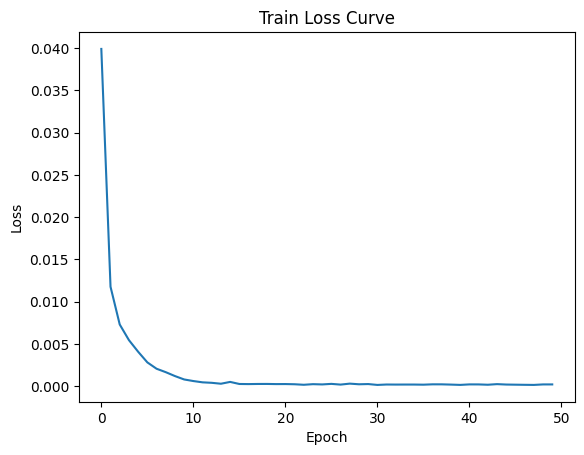

In [20]:
# Plot train loss curve
plt.title("Train Loss Curve")
plt.plot(all_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss');

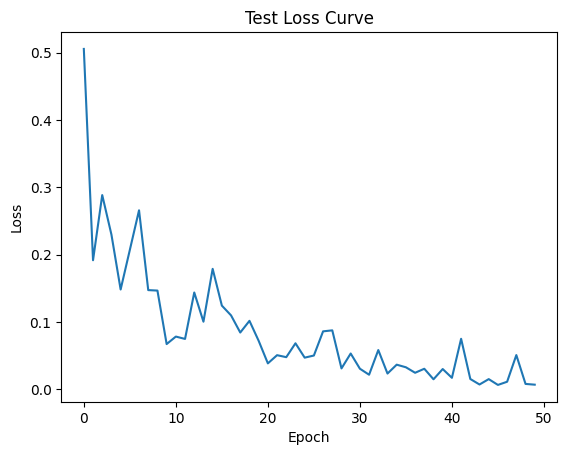

In [21]:
# Plot test loss curve
plt.title("Test Loss Curve")
plt.plot(all_test_losses);
plt.xlabel('Epoch')
plt.ylabel('Loss');

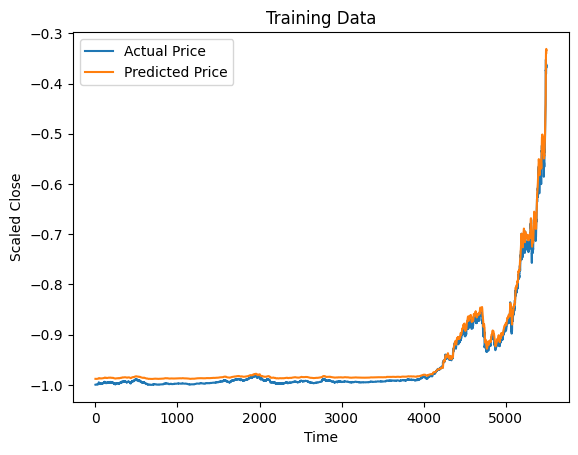

In [22]:
model.eval()

with torch.inference_mode():
    pred = model(X_train)

plt.title("Training Data")
plt.plot(y_train, label='Actual Price')
plt.plot(pred, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Scaled Close')
plt.legend()
plt.show();

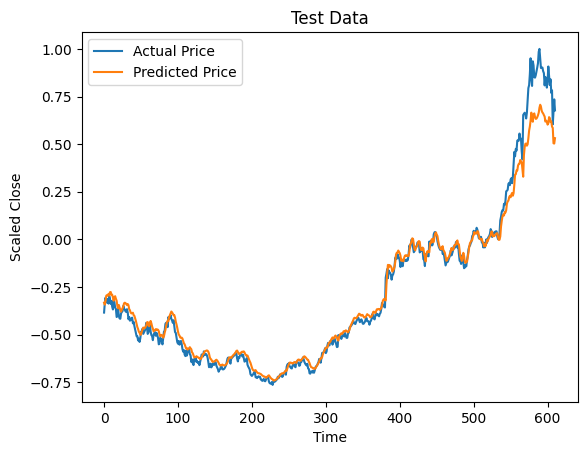

In [23]:
with torch.inference_mode():
    pred = model(X_test)

plt.title("Test Data")
plt.plot(y_test, label='Actual Price')
plt.plot(pred, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Scaled Close')
plt.legend()
plt.show();

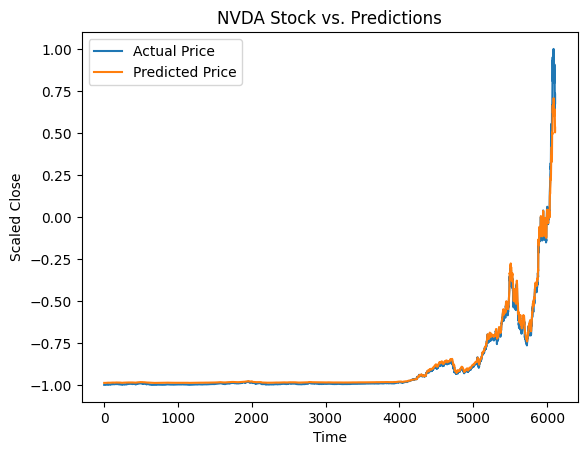

In [24]:
with torch.inference_mode():
    pred = model(X.unsqueeze(dim=2))

plt.title("NVDA Stock vs. Predictions")
plt.plot(y, label='Actual Price')
plt.plot(pred, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Scaled Close')
plt.legend()
plt.show();

## 5. Saving & Loading Model

In [25]:
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "nvidia-lstm-model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\nvidia-lstm-model.pth


In [26]:
# Create a new instance of loaded model
torch.manual_seed(42)

loaded_model = StockLSTM(
    input_size=1,
    output_size=1,
    num_layers=RNN_LAYERS,
    hidden_size=HIDDEN_SIZE
)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=False))

<All keys matched successfully>

In [28]:
# Evaluate loaded model to ensure that results are similar to base model
base_model_loss = test(model, test_dataloader, loss_fn, optimizer)
loaded_model_loss = test(loaded_model, test_dataloader, loss_fn, optimizer)

# Check if model results are similar
torch.isclose(
    torch.tensor(base_model_loss, dtype=torch.float32),
    torch.tensor(loaded_model_loss, dtype=torch.float32),
    atol=1e-04 # Absolute error tolerance
).item()

True